In [81]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, ClassifierMixin
import matplotlib.pyplot as plt
import time
import random
from scipy.io import arff
from cvxopt import matrix, solvers, spmatrix, sparse
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_blobs

solvers.options["maxiters"] = 200
solvers.options["show_progress"] = False

In [82]:
class LinBase(BaseEstimator, ClassifierMixin):
    def __init__(self, coef=None, intercept=None, class_labels=None):
        self.coef_ = coef
        self.intercept_ = intercept
        self.class_labels_ = class_labels
        
    def norm_(self, x):
        return np.sqrt(np.sum(np.square(x)))
    
    def margin(self, X, y):
        numerator = y * (X.dot(self.coef_) + self.intercept_)
        denominator = self.norm_(self.coef_)
        return numerator/denominator
    
    def decision_function(self, X):
        return self.margin(X, np.ones(X.shape[0]))
    
    def predict_proba(self, X):
        a, b = self.margin(X, np.ones((X.shape[0],)))
        return np.array([1 - 1/(1 + np.exp(-b)), 1 / (1 + np.exp(-b))]).T
    
    def predict(self, X):
        tic = time.time()
        results = np.sign(X.dot(self.coef_) + self.intercept_)
        results_mapped = self.class_labels_[1 * (results > 0)]
        print(f"Estimated time: {time.time() - tic}")
        return results_mapped
    
    def get_params(self, deep=True):
        pass
    
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self
    
    def __str__(self):
        return "{}[w={}, b={}]".format(self.__class__.__name__, self.coef_, self.intercept_)

In [83]:
class LinSvmOpt(LinBase):
    def __init__(self, sparse=False, **kwargs):
        LinBase.__init__(self, **kwargs)
        self.sv_inds_ = None
        self.sparse_ = sparse

    def fit(self, X, y):
        n_samples, n_features = X.shape
        
        X1 = np.hstack((np.ones((n_samples, 1)), X))
        G = -(y.reshape(-1, 1) @ np.ones((1, n_features+1))) * X1
        h = -np.ones((n_samples, 1))
        P = np.eye(n_features+1)
        P[0, 0] = 0
        q = np.zeros((1, n_features+1)).T
        
        
        tic = time.time()
        
        if self.sparse_: 
            results = solvers.qp(P=sparse(matrix(P)),
                                 q=matrix(q),
                                 G=sparse(matrix(G)),
                                 h=matrix(h))
        else: 
            results = solvers.qp(P=matrix(P), q=matrix(q), G=matrix(G), h=matrix(h))
            
        print(f"Estimated time: {time.time() - tic}")
        
        coefficients = np.array(results["x"])
        self.sv_inds_ = np.nonzero(np.array(results["z"]) > 1e-8)[0]
        self.coef_ = coefficients[1:].reshape(-1)
        self.intercept_ = coefficients[0]
        

In [84]:
class LinSvm(LinBase):
    def __init__(self, sparse=False, **kwargs):
        LinBase.__init__(self, **kwargs)
        self.sv_inds_ = None
        self.sparse_ = sparse

    def fit(self, X, y):
        n_samples, n_features = X.shape
        
        X1 = np.hstack((X, np.ones((n_samples, 1))))
        X1 = (y.reshape(-1, 1) @ np.ones((1, n_features+1))) * X1
        
        G = -np.vstack((np.hstack((X1, np.eye(n_samples))), np.hstack((np.zeros((n_samples, n_features+1)), np.eye(n_samples)))))
        h = -np.vstack((np.ones((n_samples,1)), np.zeros((n_samples, 1))))
        
        C = 1
        P = np.diag(np.concatenate((np.ones(n_features+1), C * np.ones(n_samples))))
        P[n_features, n_features] = 0
        q = np.vstack((np.zeros((n_features+1, 1)), np.zeros((n_samples, 1))))
          
        tic = time.time()      
        if self.sparse_: 
            results = solvers.qp(P=sparse(matrix(P)),
                                 q=matrix(q),
                                 G=sparse(matrix(G)),
                                 h=matrix(h))
        else: 
            results = solvers.qp(P=matrix(P), q=matrix(q), G=matrix(G), h=matrix(h))
            
        print(f"Estimated time: {time.time() - tic}")
        
        coefficients = np.array(results["x"])
        self.sv_inds_ = np.nonzero(np.array(results["z"]) > 1e-1)[0]
        self.coef_ = coefficients[:X.shape[1]].reshape(-1)
        self.intercept_ = coefficients[X.shape[1], 0]
        

In [85]:
def plotDecision(X, y, clf):
    grid = 100
    X1, X2 = np.meshgrid(np.linspace(np.min(X), np.max(X), grid), np.linspace(np.min(X), np.max(X), grid))
    pred = clf.predict(np.array([X1.ravel(), X2.ravel()]).T)
    pred = np.reshape(pred, (grid, grid))
    plt.contour(X1, X2, pred, 1)
    
    indexes = y==1
    plt.scatter(X[indexes, 0], X[indexes, 1], label="1", marker="*", c="green")
    plt.scatter(X[np.logical_not(indexes), 0], X[np.logical_not(indexes), 1], label="-1", marker="*", c="orange")
    if isinstance(clf, LinSvmOpt):
        plt.scatter(X[clf.sv_inds_, 0], X[clf.sv_inds_, 1], marker="s", s=100, c = "red")
    plt.show()


# Linearly separable

## Sparse = False

In [86]:
np.random.seed(0)
m, n = 2000, 2
X = np.random.rand(m, n) * 2
y = (X.dot([1,1])>2) * 2 - 1

In [87]:
clf = LinSvmOpt(class_labels=np.unique(y), sparse=False)

In [88]:
clf.fit(X, y)

Estimated time: 0.3326559066772461


Estimated time: 0.000997304916381836


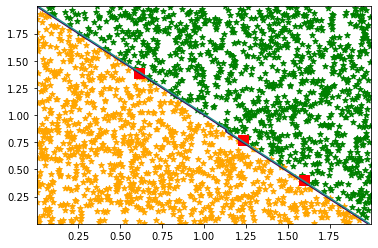

In [89]:
plotDecision(X, y, clf)

In [90]:
np.min(clf.margin(X, y))

0.000703653032484786

In [91]:
accuracy_score(y, clf.predict(X))

Estimated time: 0.0


1.0

## Sparse = True

In [92]:
clf = LinSvmOpt(class_labels=np.unique(y), sparse=True)

In [93]:
clf.fit(X, y)

Estimated time: 2.2373740673065186


Estimated time: 0.0


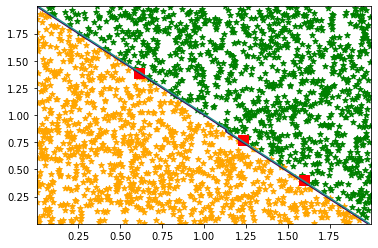

In [94]:
plotDecision(X, y, clf)

In [95]:
np.min(clf.margin(X, y))

0.0007036530324848774

In [96]:
accuracy_score(y, clf.predict(X))

Estimated time: 0.00099945068359375


1.0

# Non-linearly separable

## Sparse = False

In [97]:
X, y = make_blobs(n_samples=2000, n_features=2, random_state=0, centers=[(1, 1), (2, 2)], cluster_std=0.4)

y[y == 0] = -1
y = y.reshape(-1)

In [98]:
clf = LinSvm(class_labels=np.unique(y), sparse=False)

In [99]:
clf.fit(X, y)

Estimated time: 3.933912515640259


Estimated time: 0.0


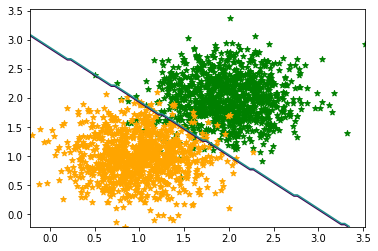

In [100]:
plotDecision(X, y, clf)

In [101]:
np.min(clf.margin(X, y))

-0.6418553778998024

In [102]:
accuracy_score(y, clf.predict(X))

Estimated time: 0.0009980201721191406


0.9695

## Sparse = True

In [103]:
clf = LinSvm(class_labels=np.unique(y), sparse=True)

In [104]:
clf.fit(X, y)

Estimated time: 0.45044732093811035


Estimated time: 0.000995635986328125


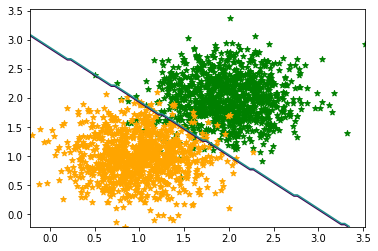

In [105]:
plotDecision(X, y, clf)

In [106]:
np.min(clf.margin(X, y))

-0.6418553779002376

In [107]:
accuracy_score(y, clf.predict(X))

Estimated time: 0.0


0.9695

---
# Sonar dataset

In [108]:
def fun(x):
    if type(x) == bytes:
        return str(x, encoding="utf-8")
    else:
        return x

In [109]:
data, meta = arff.loadarff("sonar.arff")
df = pd.DataFrame(data).applymap(fun).dropna()

In [110]:
X = df.iloc[:, 0:-1].to_numpy()
df.loc[df.Class == "Rock", "Class"] = -1
df.loc[df.Class == "Mine", "Class"] = 1
y = np.array(df.iloc[:, -1].to_list())

## Sparse = False

In [111]:
clf = LinSvmOpt(class_labels=np.unique(y), sparse=False)

In [112]:
clf.fit(X, y)

Estimated time: 0.036669254302978516


In [113]:
np.min(clf.margin(X, y))

0.0010804531353001735

In [114]:
accuracy_score(y, clf.predict(X))

Estimated time: 0.0010344982147216797


1.0

## Sparse = True

In [115]:
clf = LinSvmOpt(class_labels=np.unique(y), sparse=True)

In [116]:
clf.fit(X, y)

Estimated time: 0.14519500732421875


In [117]:
np.min(clf.margin(X, y))

0.001080453135300146

In [118]:
accuracy_score(y, clf.predict(X))

Estimated time: 0.0


1.0